# 0. About

This notebook is trying to use BSpline to reduce the dimension of data.

In [1]:
import numpy as np
from numpy.random import default_rng
import scipy.interpolate as interpolate
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import cross_validate

rs_num = 101 
rng = default_rng(rs_num)

# 1. Generating Data

For each sample, i.e. each row, we have many features, where we can see them as wavelength of spectrum for instance.

In order to have consistent random generation, it is better to re-run the entire notebook every time

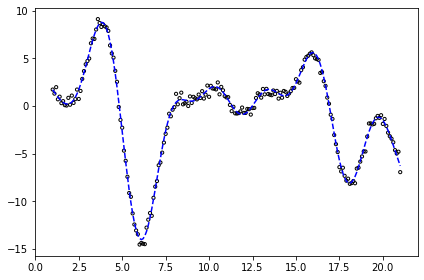

In [2]:
feature_num = 201
feature_arr = np.linspace(1, 21, feature_num)
X_mean_arr = np.zeros((feature_num, ))

# generate data mean
signal_num = 51
signal_rnd = rng.normal(size=(signal_num, 2))
for i in range(signal_num):
    X_mean_arr += np.sin(signal_rnd[i, 0]*(feature_arr+signal_rnd[i, 1]))
    
# generate data 
sample_num = 701
data_rnd = 0.4*rng.normal(size=(sample_num, feature_num))
X = np.zeros((sample_num, feature_num))
y = np.zeros((sample_num, ))
for i in range(sample_num):
    X[i, :] = X_mean_arr + data_rnd[i, :]
    y[i] = np.linalg.norm(np.exp(X[i, 1:5]))+np.linalg.norm(data_rnd[i, :])

# visualization
fig, ax = plt.subplots()

ax.plot(feature_arr, X_mean_arr, color='blue', ls='--', label='mean of measurements')
ax.scatter(feature_arr, X[0, :], s=10, fc='none', ec='black', label='one sample')

plt.tight_layout()

In [3]:
# split it into training and test
[X_train, 
 X_test, 
 y_train, 
 y_test] = train_test_split(X, y, test_size=0.20, random_state=rs_num)

# 2. Creating Baseline Regression Model

As a demo, we can use simple Linear Regression provided by sklearn, and after training on the training dataset, we can evaluate the model performance by Repeated 5-Fold Cross-Validation (within the training dataset), and evaluate the final performance on the test dataset. 

In [4]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=rs_num)
baseline_reg = LinearRegression()
cv_baseline = cross_validate(baseline_reg, X_train, y_train, cv=rkf)

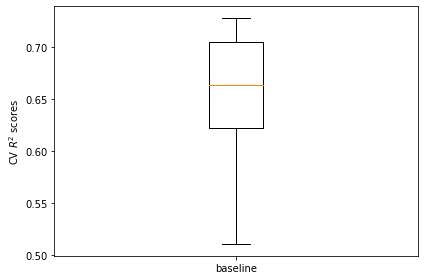

In [5]:
# visualize the scores
fig, ax = plt.subplots()

ax.boxplot([cv_baseline['test_score']], labels=['baseline'])
ax.set_ylabel(r'CV $R^2$ scores')

plt.tight_layout()

# 3. B-Spline Implementation

## 3.1. Prepare Methods for B-Spline

In [6]:
# transform the data into the shape we need
def flatten_X(X, feature_arr):
    # transform data into the shape we can use, i.e. (n, )
    sample_num, feature_num = X.shape
    ts = np.zeros((X.size, ))
    ys = np.zeros((X.size, ))

    for sample_i in range(sample_num):
        ts[sample_i*feature_num:(sample_i+1)*feature_num] = feature_arr.copy()
        ys[sample_i*feature_num:(sample_i+1)*feature_num] = X[sample_i, :].flatten()

    return [ts, ys]

In [7]:
# with above demo, we can have one function for generating BS with given knots number
def get_bs_w_knots_num(ts, ys, knots_num):
    # sort arrays based on ts (required by `interpolate.splrep`)
    ts_sorted_ind = ts.argsort()
    ts_sorted = ts[ts_sorted_ind]
    ys_sorted = ys[ts_sorted_ind]
    
    # creating knots
    qs = np.linspace(0, 1, knots_num+2)[1:-1]
    knots = np.quantile(ts_sorted, qs)
    
    # prepare parameters for cubic BS
    t, c, k = interpolate.splrep(ts_sorted, ys_sorted, t=knots, k=3)
    
    # BS
    bs_obj = interpolate.BSpline(t, c, k, extrapolate=False)
    
    return bs_obj

## 3.2. Find the Optimal Knots Number

We can find the optimal knots number by cross-validation.

In [8]:
# determine the optimal knots number by cross-validation
rkf_knots_num = RepeatedKFold(n_splits=5, n_repeats=3, random_state=rs_num)

knots_num_list = np.arange(3, 50+1)
mse_cv_arr = np.zeros((knots_num_list.size, 15))
ts_train, ys_train = flatten_X(X_train, feature_arr)
for knots_ind, knots_num in enumerate(knots_num_list):
    cv_ind = 0
    for cv_train_ind, cv_test_ind in rkf_knots_num.split(ts_train):
        ts_cv_train, ys_cv_train = ts_train[cv_train_ind], ys_train[cv_train_ind]
        ts_cv_test, ys_cv_test = ts_train[cv_test_ind], ys_train[cv_test_ind]
        
        # get bs
        bs_obj = get_bs_w_knots_num(ts_cv_train, ys_cv_train, knots_num)

        # predict
        ys_pred = bs_obj(ts_cv_test)
        ys_true = ys_cv_test

        # MSE
        mse_cv_arr[knots_ind, cv_ind] = mean_squared_error(ys_true, ys_pred)
        cv_ind += 1

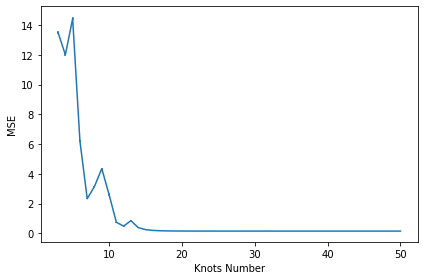

In [9]:
# check MSE for knots number list
mse_cv_std = mse_cv_arr.std(axis=1)
mse_cv_mean = mse_cv_arr.mean(axis=1)

fig, ax = plt.subplots()

ax.errorbar(knots_num_list, mse_cv_mean, yerr=mse_cv_std)
ax.set_xlabel('Knots Number')
ax.set_ylabel('MSE')

plt.tight_layout()

In [10]:
# optiaml knots number
optimal_knots_num = knots_num_list[mse_cv_mean.argmin()]
print(optimal_knots_num)

42


## 3.3. B-Spline Dimension Reduction

In [11]:
optimal_bs_obj = get_bs_w_knots_num(ts_train, ys_train, optimal_knots_num)
ts_test, ys_test = flatten_X(X_test, feature_arr)

# construct new data
bs_feature_num = optimal_bs_obj.c.shape[0]
bs_X_train = np.zeros((X_train.shape[0], bs_feature_num))
bs_y_train = y_train
bs_X_test = np.zeros((X_test.shape[0], bs_feature_num))
bs_y_test = y_test

for sample_i in range(bs_X_train.shape[0]):
    bs_train = get_bs_w_knots_num(feature_arr, X_train[sample_i].flatten(), optimal_knots_num)
    bs_X_train[sample_i, :] = bs_train.c.copy()

for sample_i in range(bs_X_test.shape[0]):
    bs_test = get_bs_w_knots_num(feature_arr, X_test[sample_i].flatten(), optimal_knots_num)
    bs_X_test[sample_i, :] = bs_test.c.copy()

In [12]:
# check out the training
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=rs_num)
bs_reg = LinearRegression()
cv_bs = cross_validate(bs_reg, bs_X_train, bs_y_train, cv=rkf)

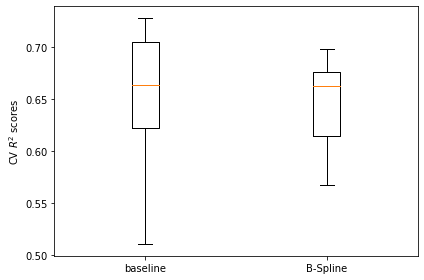

In [13]:
# visualize the scores
fig, ax = plt.subplots()

ax.boxplot(
    [cv_baseline['test_score'], cv_bs['test_score']], 
    labels=['baseline', 'B-Spline']
)
ax.set_ylabel(r'CV $R^2$ scores')

plt.tight_layout()

It looks the prediction performance of the B-Spline reduction is not quite better.
We can also check out the performance of models on the test dataset.

In [14]:
baseline_reg = LinearRegression().fit(X_train, y_train)
bs_reg = LinearRegression().fit(bs_X_train, bs_y_train)

print("The baseline score on the test dataset is: {:.3f}".format(baseline_reg.score(X_test, y_test)))
print("The B-Spline score on the test dataset is: {:.3f}".format(bs_reg.score(bs_X_test, bs_y_test)))

The baseline score on the test dataset is: 0.654
The B-Spline score on the test dataset is: 0.560


The result is pretty consistent with our CV results.